## Credit Card Fraud Detection

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

plt.rcParams['figure.figsize'] = (15, 10)

import warnings
warnings.filterwarnings("ignore")

C:\Anaconda_latest\envs\creditcardfrauddetection\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv('fraudTrain.csv')

In [3]:
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

In [23]:
# Dropping columns that are not important
drop_columns = ['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'first', 'last',
               'street', 'zip', 'dob', 'trans_num', 'unix_time']
df.drop(drop_columns, axis = 1, inplace = True)

In [24]:
df.head()

,merchant,category,amt,gender,city,state,lat,long,city_pop,job,merch_lat,merch_long,is_fraud
0,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,Moravian Falls,NC,36.0788,-81.1781,3495,"Psychologist, counselling",36.011293,-82.048315,0
1,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,Orient,WA,48.8878,-118.2105,149,Special educational needs teacher,49.159047,-118.186462,0
2,fraud_Lind-Buckridge,entertainment,220.11,M,Malad City,ID,42.1808,-112.2620,4154,Nature conservation officer,43.150704,-112.154481,0
3,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,M,Boulder,MT,46.2306,-112.1138,1939,Patent attorney,47.034331,-112.561071,0
4,fraud_Keeling-Crist,misc_pos,41.96,M,Doe Hill,VA,38.4207,-79.4629,99,Dance movement psychotherapist,38.674999,-78.632459,0


In [25]:
categorical_features = ['merchant', 'category', 'gender', 'city', 'state', 'job']

df_categorical = df[categorical_features]

In [26]:
df_categorical['category'].value_counts().values

array([131659, 123638, 123115, 116672, 113035,  97543,  94014,  91461,
        90758,  85879,  79655,  63287,  45452,  40507], dtype=int64)

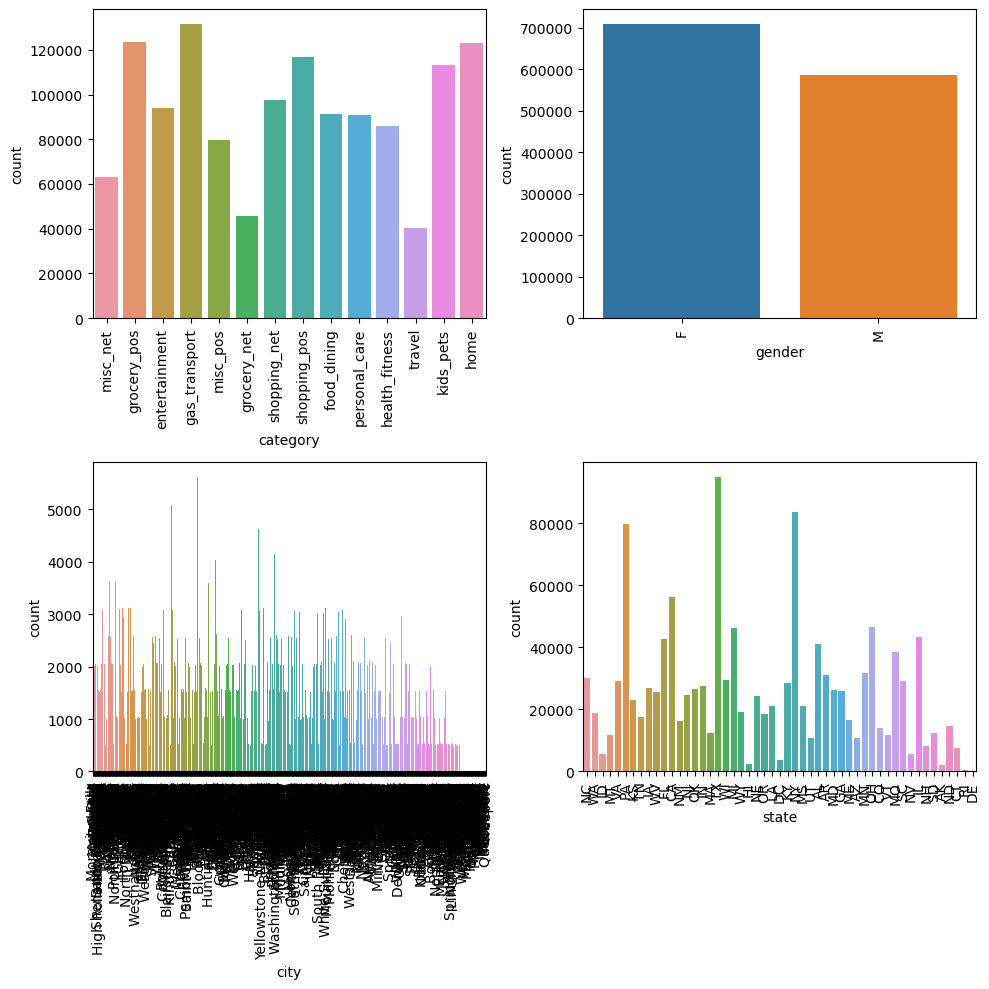

In [27]:
# This code cell plots the count of each of the categories with countplots
fig, ax = plt.subplots(2, 2, figsize = (10, 10))

sns.countplot(x = 'category', data = df_categorical, ax = ax[0, 0])
sns.countplot(x = 'gender', data = df_categorical, ax = ax[0, 1])
sns.countplot(x = 'city', data = df_categorical, ax = ax[1, 0])
sns.countplot(x = 'state', data = df_categorical, ax = ax[1, 1])

# Rotate x-tick labels by 45 degrees for all subplots
for i in range(2):
    for j in range(2):
        ax[i, j].set_xticklabels(ax[i, j].get_xticklabels(), rotation=90)
    
plt.tight_layout()
plt.show()

### Checking Outliers in Data

In [29]:
df.head()

,merchant,category,amt,gender,city,state,lat,long,city_pop,job,merch_lat,merch_long,is_fraud
0,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,Moravian Falls,NC,36.0788,-81.1781,3495,"Psychologist, counselling",36.011293,-82.048315,0
1,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,Orient,WA,48.8878,-118.2105,149,Special educational needs teacher,49.159047,-118.186462,0
2,fraud_Lind-Buckridge,entertainment,220.11,M,Malad City,ID,42.1808,-112.2620,4154,Nature conservation officer,43.150704,-112.154481,0
3,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,M,Boulder,MT,46.2306,-112.1138,1939,Patent attorney,47.034331,-112.561071,0
4,fraud_Keeling-Crist,misc_pos,41.96,M,Doe Hill,VA,38.4207,-79.4629,99,Dance movement psychotherapist,38.674999,-78.632459,0


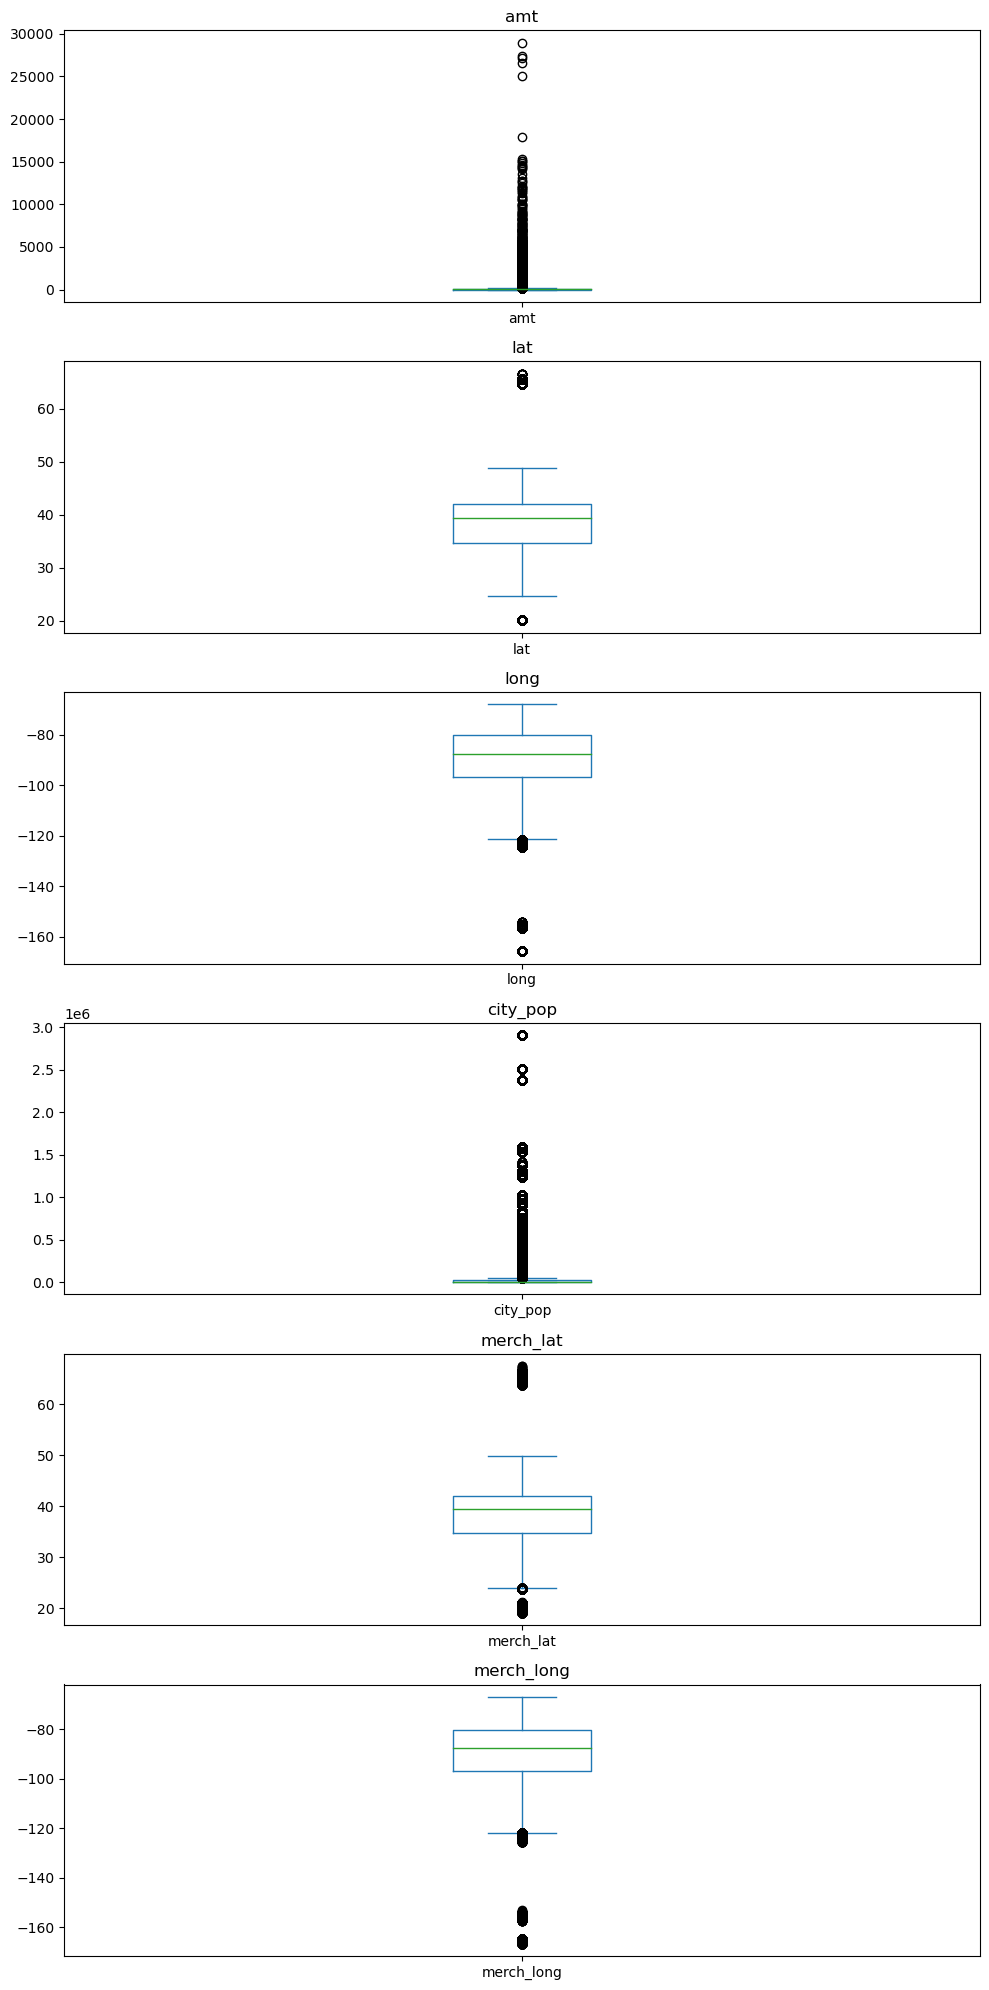

In [39]:
numerical_features = ['amt', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long']
fig, axes = plt.subplots(nrows = len(numerical_features), ncols = 1, figsize = (10, 20))

for i, col in enumerate(numerical_features):
    df[col].plot(kind = 'box', ax = axes[i])
    axes[i].set_title(col)
    
plt.tight_layout()    
plt.show()

In [43]:
np.percentile(df['amt'], [25, 50, 75, 95, 99])

array([  9.65  ,  47.52  ,  83.14  , 196.31  , 545.9926])

In [47]:
len(df[df['amt'] > 500])

15631

In [48]:
len(df[df['amt'] < 500])

1281044

In [49]:
df = df[df['amt'] < 500]

<AxesSubplot: >

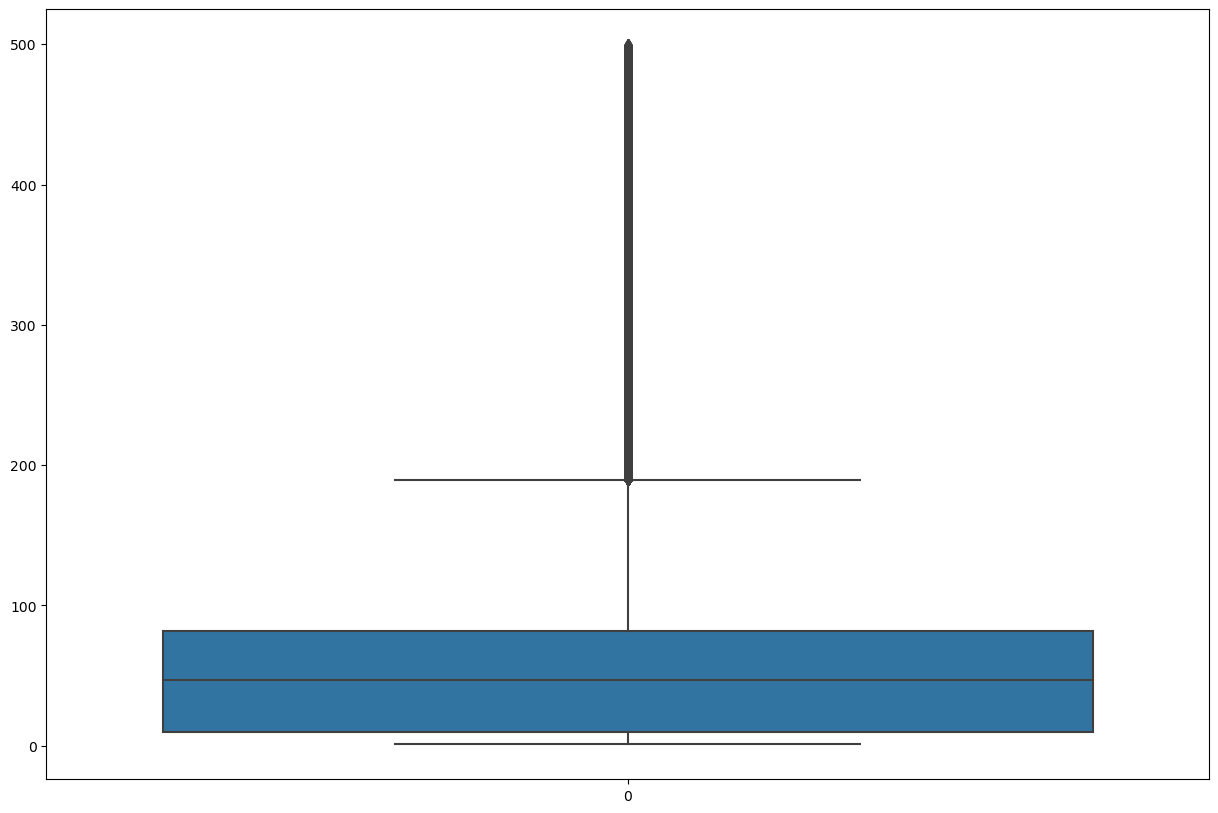

In [50]:
sns.boxplot(df['amt'])

In [51]:
np.percentile(df['city_pop'], [25, 50, 75, 95, 99])

array([7.430000e+02, 2.456000e+03, 2.032800e+04, 5.257130e+05,
       1.577385e+06])

In [52]:
np.percentile(df['city_pop'], [99, 99.1, 99.2, 99.5, 99.9])

array([1577385., 1595797., 1595797., 2383912., 2906700.])

In [54]:
len(df[df['city_pop'] > 1.577385e+06])

11684

In [56]:
len(df[df['city_pop'] > 1.577385e+06]) / len(df) * 100

0.9120685940529755

In [57]:
df = df[df['city_pop'] < 1.577385e+06]

In [59]:
len(df)

1266831

In [62]:
df['is_fraud'].value_counts()

0    1263018
1       3813
Name: is_fraud, dtype: int64

<AxesSubplot: >

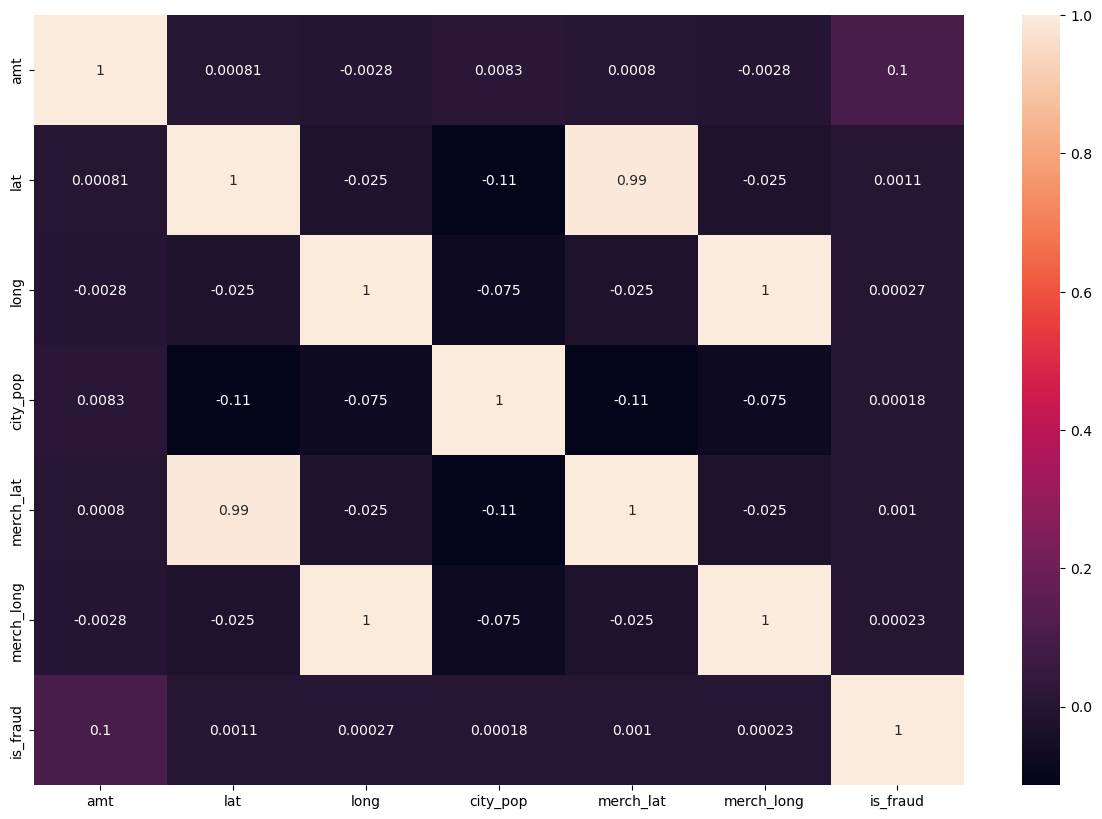

In [63]:
sns.heatmap(df.corr(), annot = True)

In [64]:
df['is_fraud'].value_counts()

0    1263018
1       3813
Name: is_fraud, dtype: int64

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1266831 entries, 0 to 1296674
Data columns (total 13 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   merchant    1266831 non-null  object 
 1   category    1266831 non-null  object 
 2   amt         1266831 non-null  float64
 3   gender      1266831 non-null  object 
 4   city        1266831 non-null  object 
 5   state       1266831 non-null  object 
 6   lat         1266831 non-null  float64
 7   long        1266831 non-null  float64
 8   city_pop    1266831 non-null  int64  
 9   job         1266831 non-null  object 
 10  merch_lat   1266831 non-null  float64
 11  merch_long  1266831 non-null  float64
 12  is_fraud    1266831 non-null  int64  
dtypes: float64(5), int64(2), object(6)
memory usage: 135.3+ MB


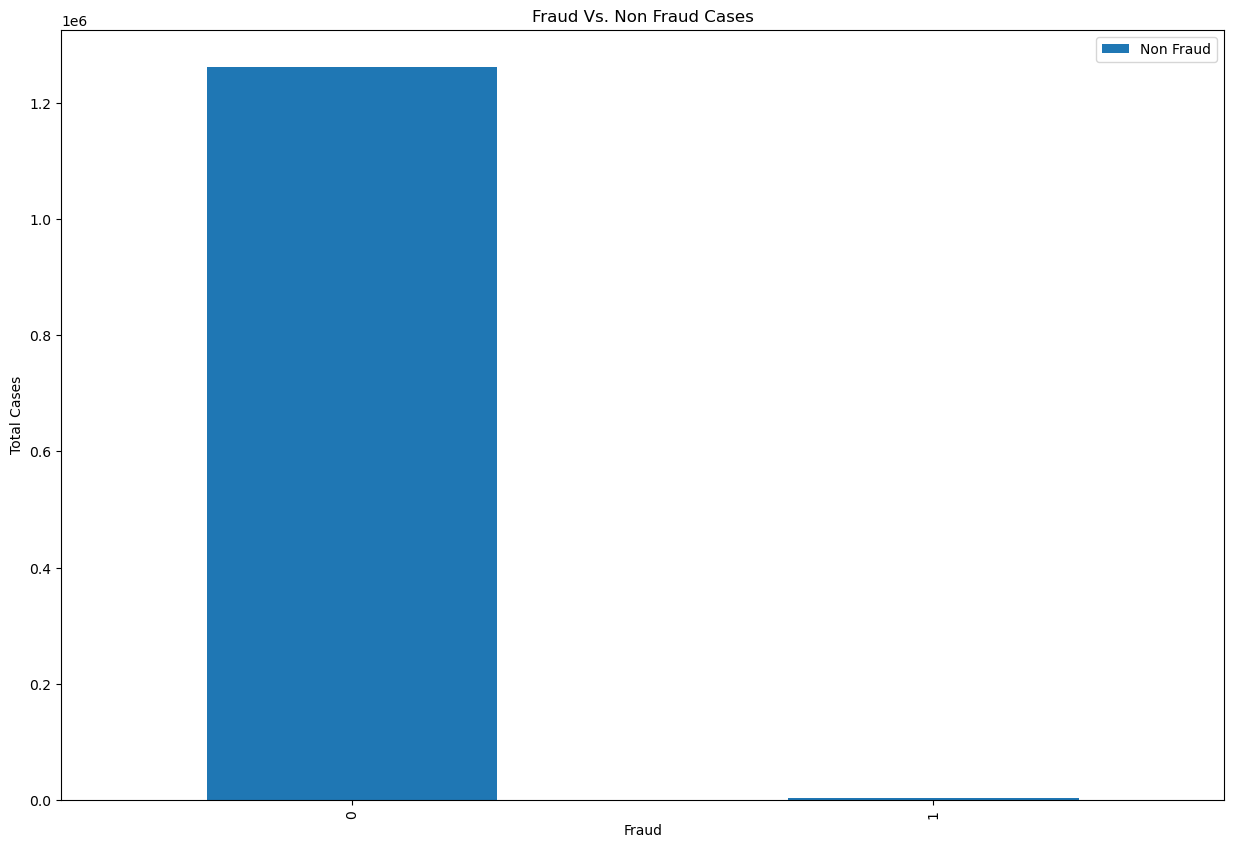

In [66]:
df['is_fraud'].value_counts().plot(kind = 'bar')
plt.title("Fraud Vs. Non Fraud Cases")
plt.xlabel("Fraud")
plt.ylabel("Total Cases")
plt.legend(['Non Fraud', 'Fraud'])
plt.show()

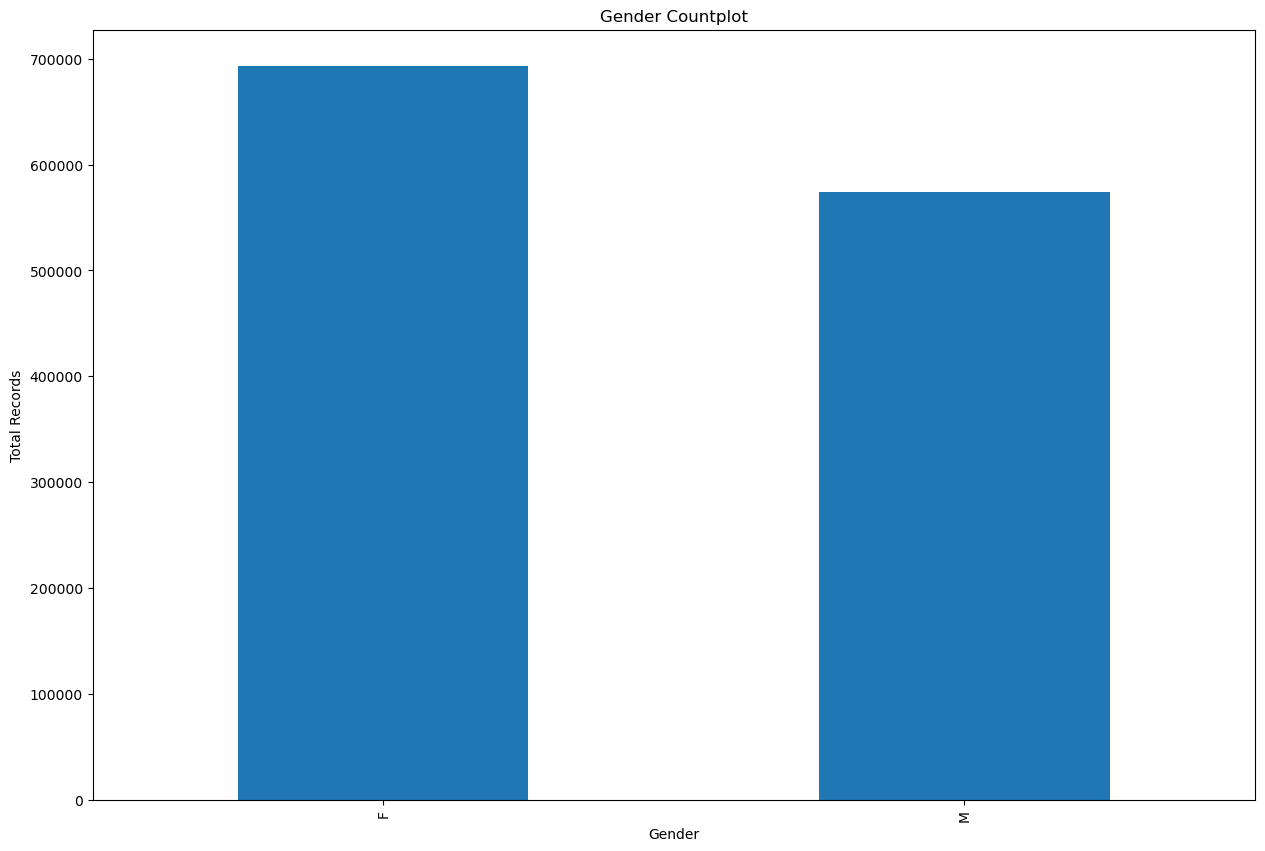

In [67]:
df['gender'].value_counts().plot(kind = 'bar')
plt.title("Gender Countplot")
plt.xlabel("Gender")
plt.ylabel("Total Records")
plt.show()

In [68]:
X = df.drop(['is_fraud'], axis = 1)
y = df['is_fraud'].values.reshape(-1, 1)

In [69]:
print("The shape of the input data: {}".format(X.shape))
print("The shape of the output data: {}".format(y.shape))

The shape of the input data: (1266831, 12)
The shape of the output data: (1266831, 1)


In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 101,
                                                   stratify = y)

In [71]:
fraud_cases = df[df['is_fraud'] == 1]
non_fraud_cases = df[df['is_fraud'] == 0]

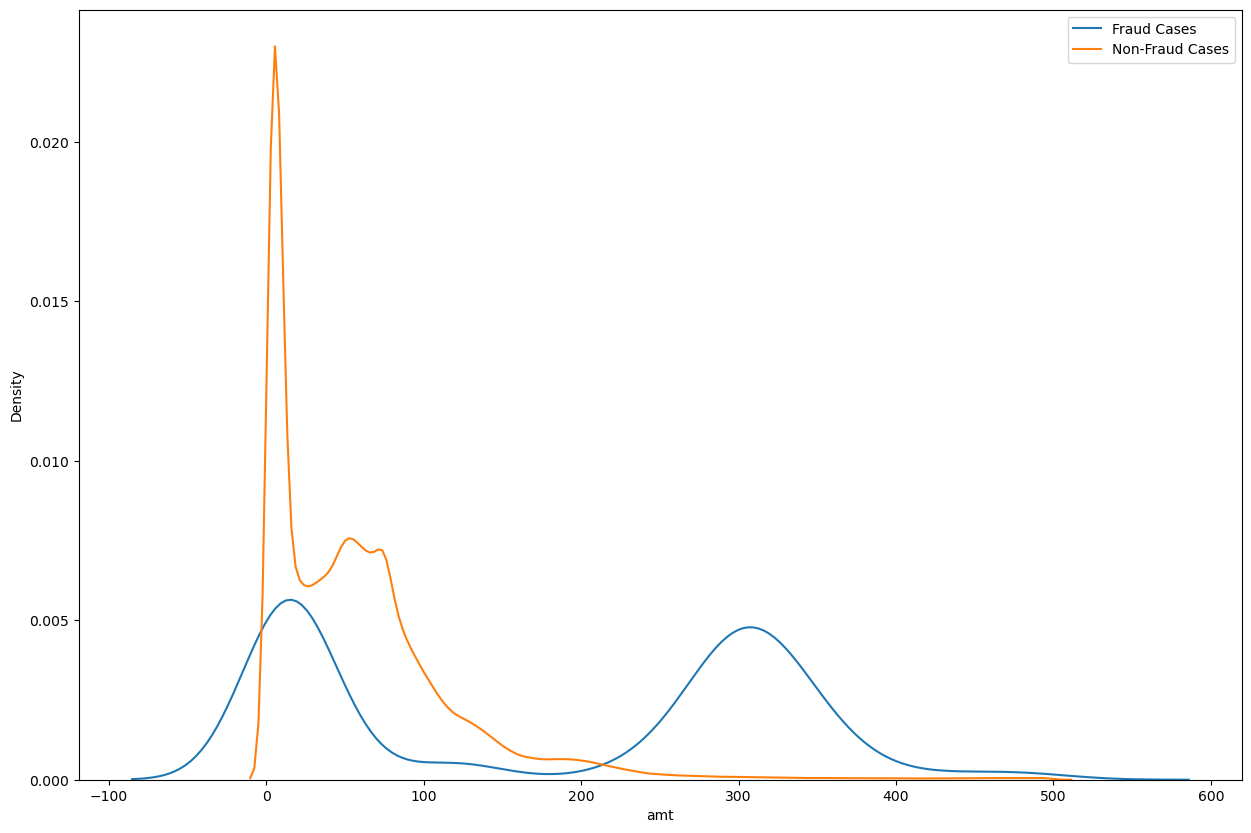

In [72]:
sns.kdeplot(fraud_cases['amt'], label = "Fraud Cases")
sns.kdeplot(non_fraud_cases['amt'], label = "Non-Fraud Cases")
plt.legend()
plt.show()

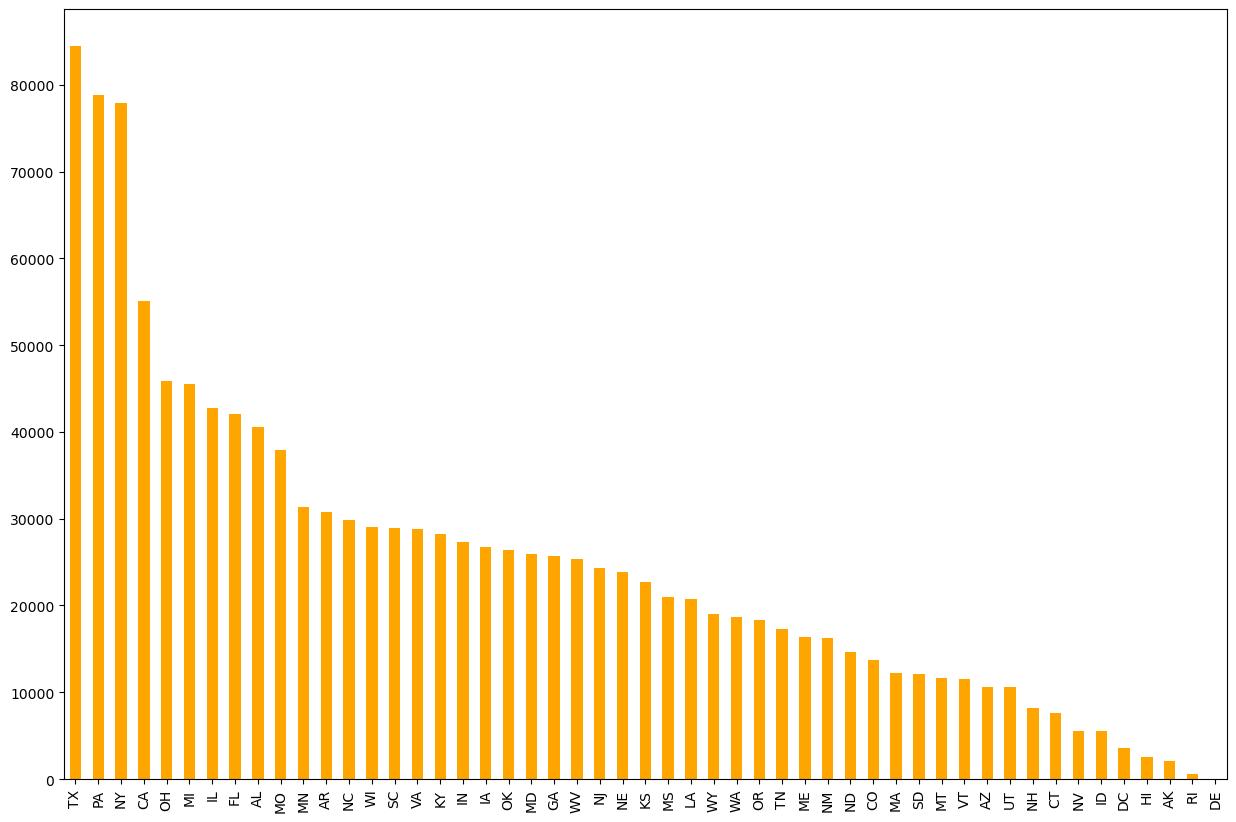

In [73]:
df['state'].value_counts().plot(kind = 'bar', color = 'orange')
plt.show()

<AxesSubplot: >

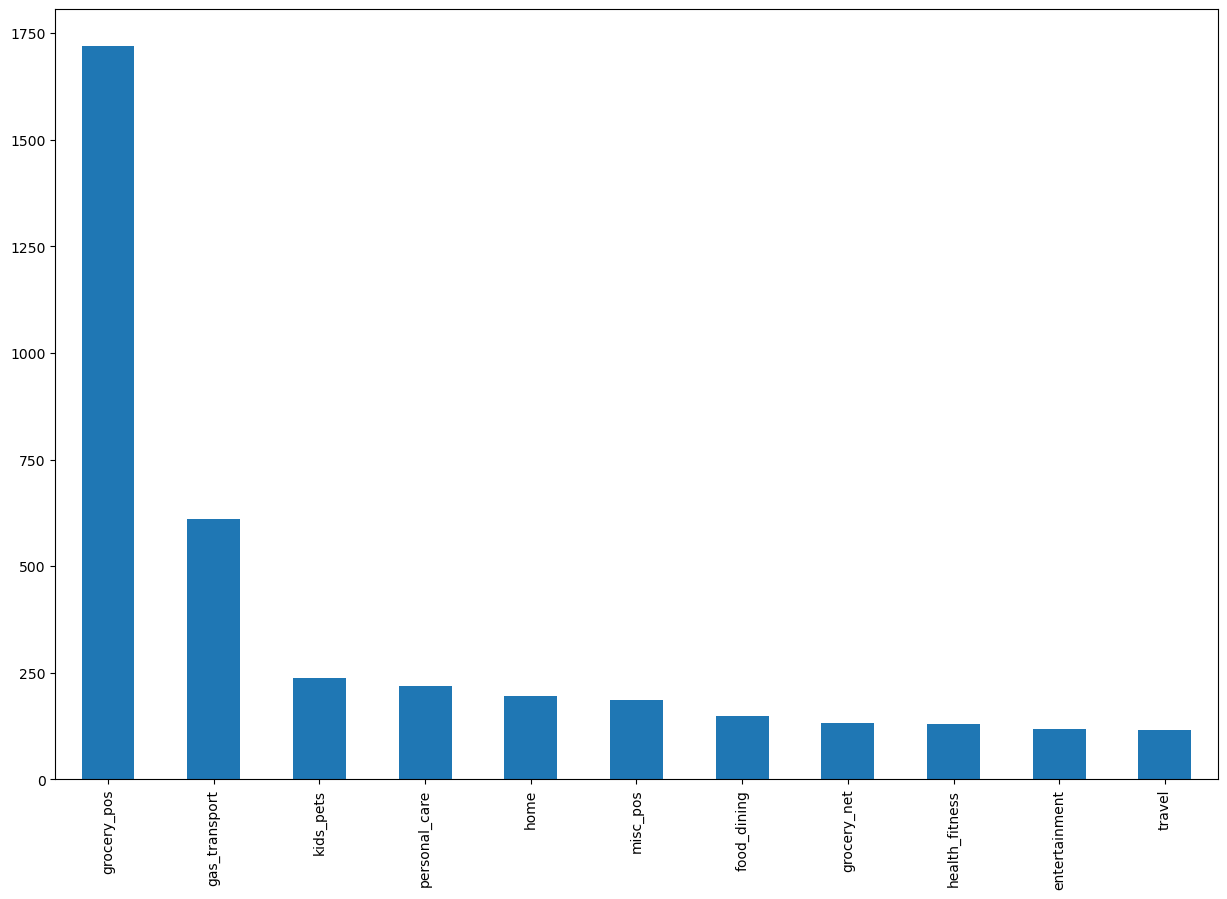

In [74]:
fraud_cases['category'].value_counts().plot(kind = 'bar')

<AxesSubplot: >

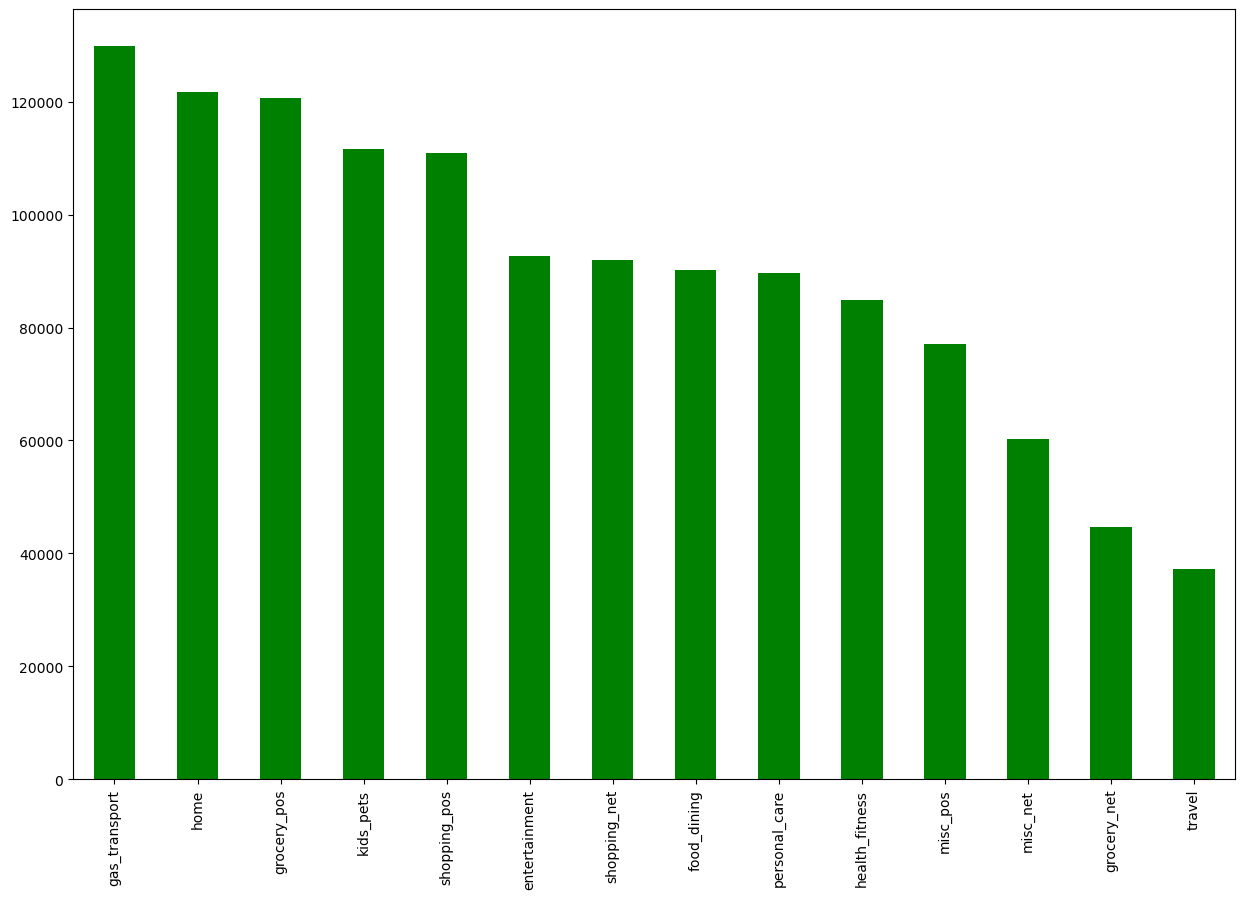

In [75]:
non_fraud_cases['category'].value_counts().plot(kind = 'bar', color = 'green')

<AxesSubplot: >

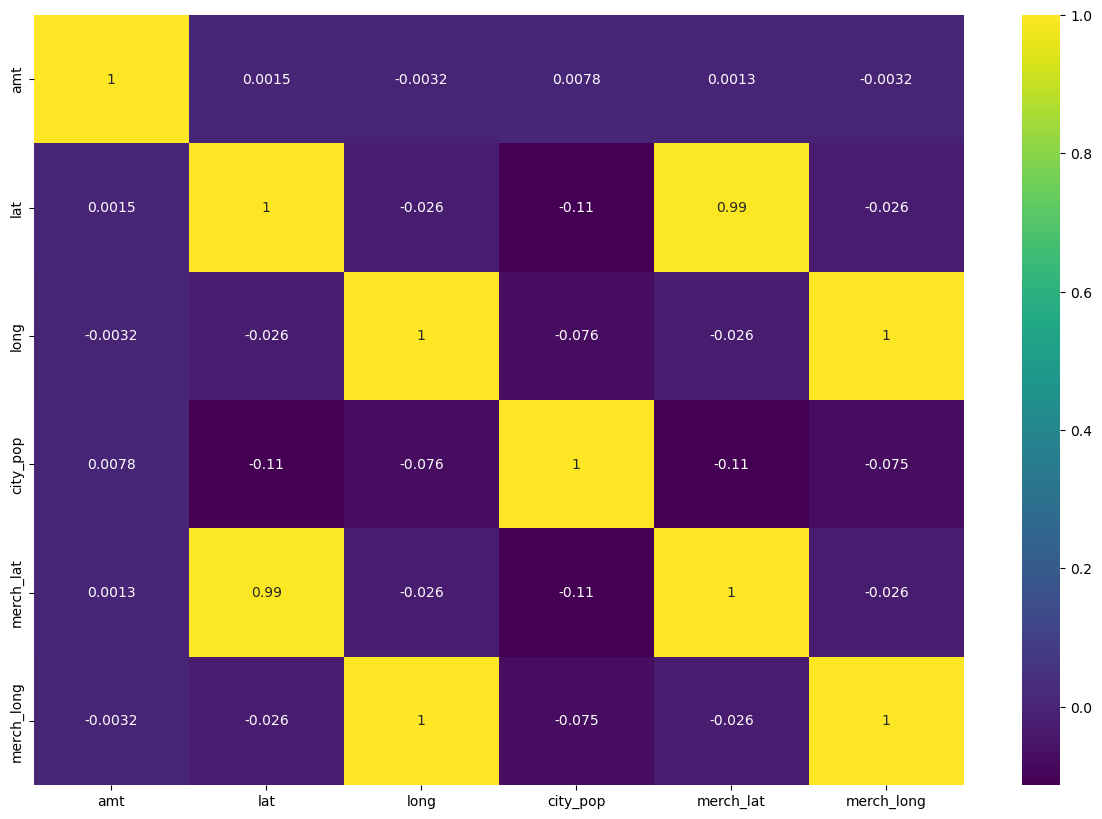

In [76]:
sns.heatmap(X_train.corr(), annot = True, cmap = 'viridis')

<AxesSubplot: >

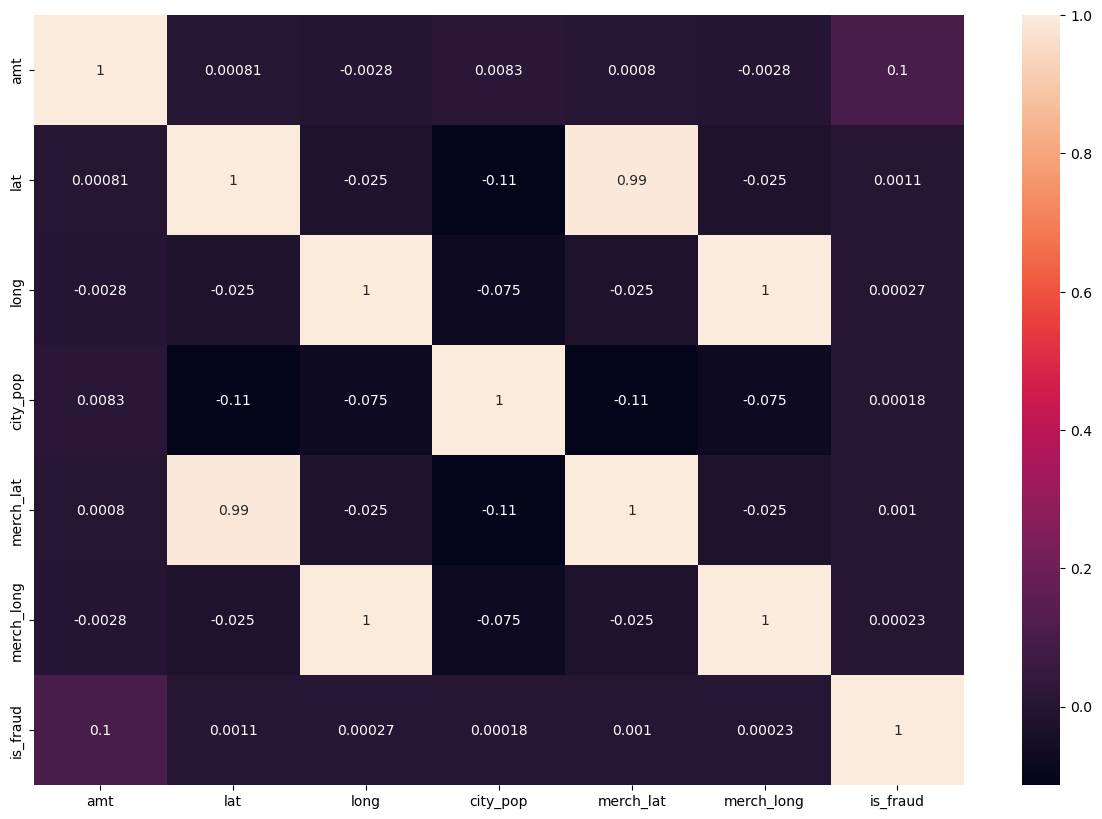

In [77]:
sns.heatmap(df.corr(), annot = True)

### Feature Engineering

In [78]:
# Defining utility functions that are used later in code 

def euclidean_distance(lat1, long1, lat2, long2):
    
    dlat = lat2 - lat1
    dlong = long2 - long1
    euclidean_distance = (dlat ** 2 + dlong ** 2) ** 0.5
    
    return euclidean_distance

In [79]:
lat1 = X_train['lat']
long1 = X_train['long']
lat2 = X_train['merch_lat']
long2 = X_train['merch_long']

X_train['euclidean_distance'] = euclidean_distance(lat1, long1, lat2, long2)

In [80]:
lat1 = X_test['lat']
long1 = X_test['long']
lat2 = X_test['merch_lat']
long2 = X_test['merch_long']

X_test['euclidean_distance'] = euclidean_distance(lat1, long1, lat2, long2)

<AxesSubplot: xlabel='euclidean_distance', ylabel='Density'>

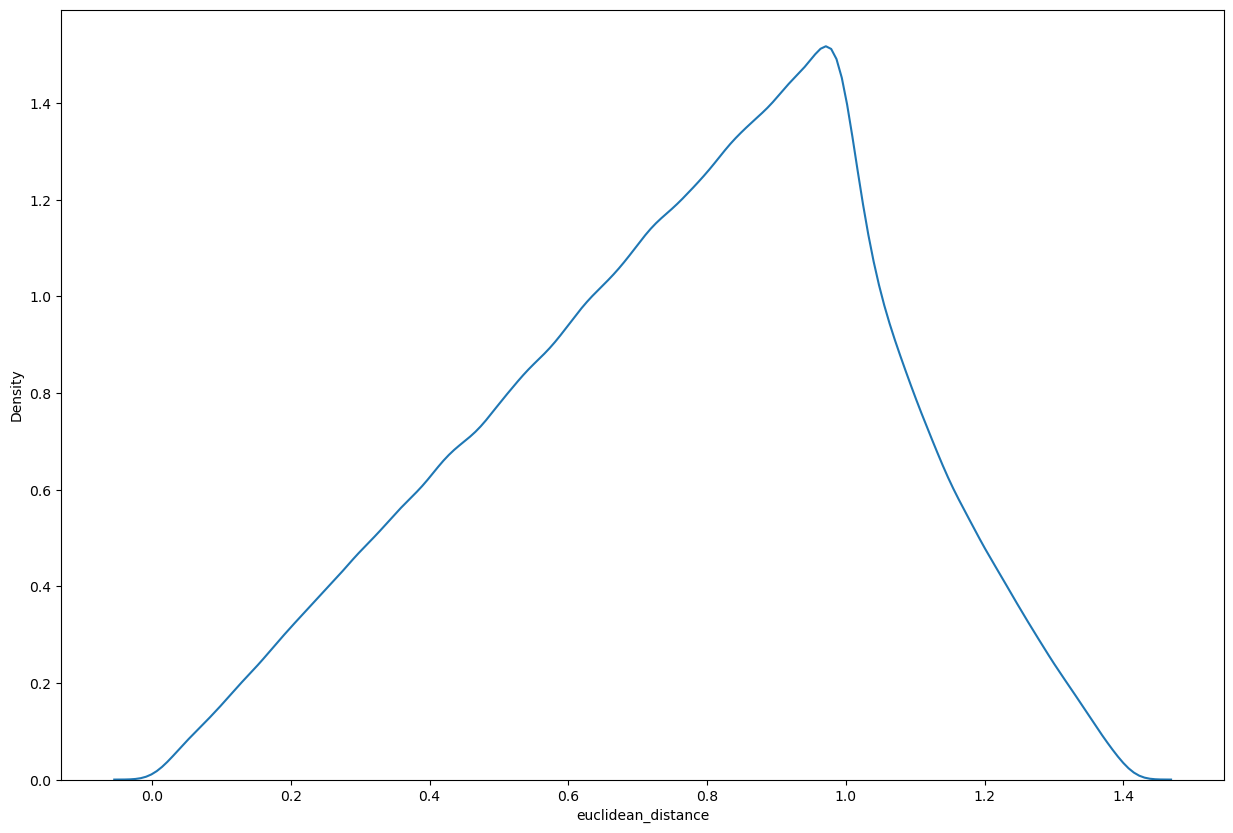

In [81]:
sns.kdeplot(X_train['euclidean_distance'])

In [82]:
X_train.head()

,merchant,category,amt,gender,city,state,lat,long,city_pop,job,merch_lat,merch_long,euclidean_distance
1001703,fraud_Windler LLC,kids_pets,44.23,M,Greenview,CA,41.5403,-122.9366,308,Call centre manager,41.416485,-122.654035,0.308501
163978,fraud_Volkman PLC,food_dining,21.22,F,Annapolis,MD,39.0305,-76.5515,92106,"Accountant, chartered certified",39.709663,-76.270692,0.734926
1123531,fraud_Bernhard Inc,gas_transport,77.33,M,Shelter Island,NY,41.0640,-72.3366,1858,Clinical biochemist,40.603320,-72.375867,0.462350
38755,fraud_Koelpin and Sons,misc_net,9.55,M,Minnesota Lake,MN,43.8295,-93.8282,1087,Music tutor,43.580610,-93.500030,0.411876
1186315,"fraud_Graham, Hegmann and Hammes",food_dining,16.58,F,Centerview,MO,38.7897,-93.8702,2368,Electronics engineer,38.626694,-93.058753,0.827658


In [83]:
from sklearn.preprocessing import OneHotEncoder

In [84]:
categorical_features = ['merchant', 'category', 'gender', 'city', 'state', 'job']
X_train_numerical = X_train.drop(categorical_features, axis = 1)
X_test_numerical = X_test.drop(categorical_features, axis = 1)

In [85]:
X_train_categorical = X_train[categorical_features]
X_test_categorical = X_test[categorical_features]

In [87]:
encoder = OneHotEncoder(handle_unknown = 'ignore')
X_train_ohe = encoder.fit_transform(X_train_categorical)
X_test_ohe = encoder.transform(X_test_categorical)

In [88]:
from scipy.sparse import hstack

In [89]:
X_train_numerical.drop(['city_pop'], axis = 1, inplace = True)
X_test_numerical.drop(['city_pop'], axis = 1, inplace = True)

In [90]:
X_train_numerical['dist_to_amt'] = X_train_numerical['euclidean_distance'] / X_train_numerical['amt']
X_test_numerical['dist_to_amt'] = X_test_numerical['euclidean_distance'] / X_test_numerical['amt']

In [91]:
X_train_encoded = hstack((X_train_numerical.values, X_train_ohe))
X_test_encoded = hstack((X_test_numerical.values, X_test_ohe))

In [92]:
X_train_encoded.shape

(886781, 2143)

In [93]:
X_train_numerical.head()

,amt,lat,long,merch_lat,merch_long,euclidean_distance,dist_to_amt
1001703,44.23,41.5403,-122.9366,41.416485,-122.654035,0.308501,0.006975
163978,21.22,39.0305,-76.5515,39.709663,-76.270692,0.734926,0.034634
1123531,77.33,41.0640,-72.3366,40.603320,-72.375867,0.462350,0.005979
38755,9.55,43.8295,-93.8282,43.580610,-93.500030,0.411876,0.043128
1186315,16.58,38.7897,-93.8702,38.626694,-93.058753,0.827658,0.049919


### Training an ML Model

In [94]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix

In [110]:
# This cell can take about 5 mins as we are training a large dataset
xgb_model = xgb.XGBClassifier(n_estimators = 25, max_depth = 2, random_state = 101)
xgb_model.fit(X_train_encoded, y_train)

[13:15:31] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=2, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=25, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=101,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [111]:
y_predictions = xgb_model.predict(X_test_encoded)

In [112]:
print(classification_report(y_test, y_predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    378906
           1       0.94      0.62      0.75      1144

    accuracy                           1.00    380050
   macro avg       0.97      0.81      0.87    380050
weighted avg       1.00      1.00      1.00    380050



In [113]:
confusion_matrix(y_test, y_predictions)

array([[378862,     44],
       [   435,    709]], dtype=int64)

### Training an ML Model with Feature Engineering

### SMOTE Oversampling

In [114]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state = 101)

X_train_oversampled_tuple = smote.fit_resample(X_train_encoded, y_train)

In [115]:
# Reading the input and output from the tuple
X_train_oversampled = X_train_oversampled_tuple[0]
y_train_oversampled = X_train_oversampled_tuple[1]

In [116]:
print("The initial shape of the training dataset: {}".format(X_train_encoded.shape))
print("The shape of oversampled training dataset: {}".format(X_train_oversampled.shape))

The initial shape of the training dataset: (886781, 2143)
The shape of oversampled training dataset: (1768224, 2143)


In [126]:
# This cell can take about 5-10 mins as we are training a large dataset
xgb_model = xgb.XGBClassifier(n_estimators = 300, max_depth = 3, random_state = 101, n_jobs = 30)
xgb_model.fit(X_train_oversampled, y_train_oversampled)

[13:24:43] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=300, n_jobs=30,
              num_parallel_tree=1, predictor='auto', random_state=101,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [127]:
y_predictions = xgb_model.predict(X_test_encoded)

In [128]:
print(classification_report(y_test, y_predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    378906
           1       0.58      0.70      0.64      1144

    accuracy                           1.00    380050
   macro avg       0.79      0.85      0.82    380050
weighted avg       1.00      1.00      1.00    380050



### Scaling

In [64]:
from sklearn.preprocessing import MaxAbsScaler

scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train_oversampled)
X_test_scaled = scaler.transform(X_test_encoded)

In [66]:
# This cell can take about 5 minutes to run as it is training on oversampled data
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train_scaled, y_train_oversampled)

[13:41:56] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [67]:
y_predictions = xgb_model.predict(X_test_scaled)

In [68]:
print(classification_report(y_test, y_predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    386751
           1       0.59      0.81      0.69      2252

    accuracy                           1.00    389003
   macro avg       0.80      0.91      0.84    389003
weighted avg       1.00      1.00      1.00    389003



<AxesSubplot: >

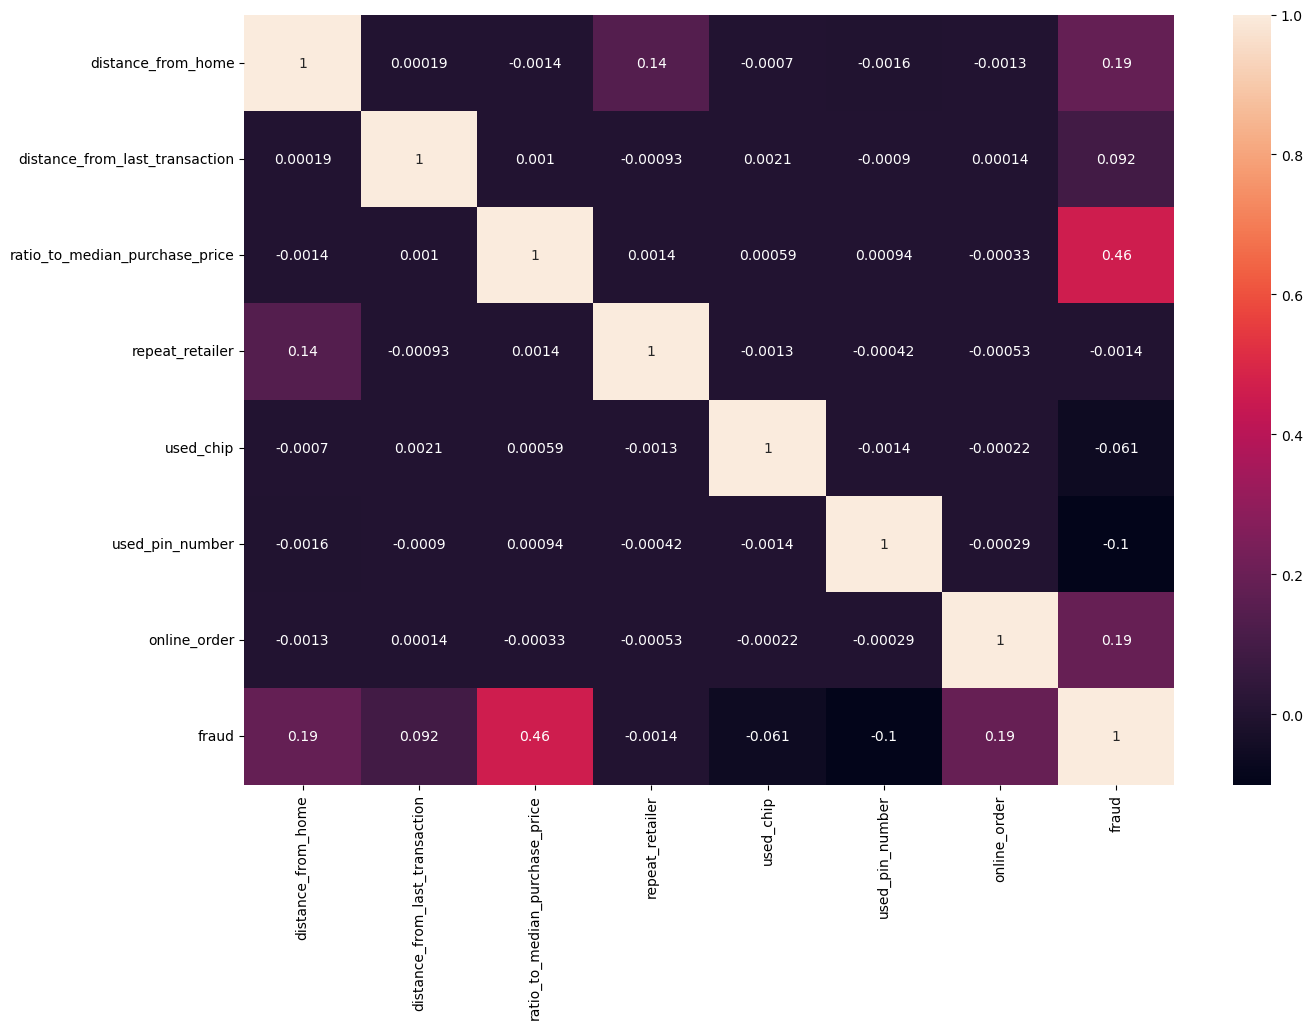

In [103]:
df_corr = df.corr()
sns.heatmap(df_corr, annot = True)